## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration matrix using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# These are the 3D points of the reference/undistorted image. Z axis points are all 0 as the reference image
# is on a flat surface on z = 0. 6 by 9 internal points grid.
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
#        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#        cv2.imshow('img',img)
#        cv2.waitKey(500)

cv2.destroyAllWindows()

### check size of all images (calibration and test images)

In [2]:
# Before computing camera calibration parameters, let's make sure dimensions of all images are same as the 
# cv2.calibrateCamera() API depends on the image shape being used. In the test below all images (camera calibration
#images and test images have same dimension (720, 1280, 3), except camera_cal/calibration7.jpg which is (721, 1281, 3) )
#Will not use calibration7.jpg in camera matrix and distortion parameter determination

# images = glob.glob('camera_cal/calibration*.jpg')
# print ("shape of chess board images")
# for img in images:
#     print (cv2.imread(img).shape, img)
# print ("shape of test images")
# images = glob.glob('test_images/test*.jpg')
# for img in images:
#     print (cv2.imread(img).shape)
# print ("shape of straight line test images")
# images = glob.glob('test_images/straight_lines*.jpg')
# for img in images:
#     print (cv2.imread(img).shape)

## Compute distortion coefficients given a set of chessboard images

In [3]:
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# TODO - check ret for success.
# mtx is the camera matrix which maps points from 3D space to 2D
# dist are the camera distortion parameters
# print (mtx.shape, dist)

### Optional step to pickle/persistently save the camera matrix and distortion parameters

In [4]:
import pickle

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "output_images/camera_params.p", "wb" ) )

## Generate undistorted images

In [5]:
%matplotlib inline

def visualize_undistorted_image(img, dst):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img[:,:,::-1])
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst[:,:,::-1])
    ax2.set_title('Undistorted Image', fontsize=30)    

# Unit Test: Generate undistorted images
# images = glob.glob('test_images/test*.jpg')
# for img in images:
#     dst = cv2.undistort(cv2.imread(img), mtx, dist, None, mtx)
#     cv2.imwrite('output_images/undistorted_'+img.split('/')[1], dst)
#     visualize_undistorted_image(cv2.imread(img), dst)

# images = glob.glob('test_images/straight_lines*.jpg')
# for img in images:
#     dst = cv2.undistort(cv2.imread(img), mtx, dist, None, mtx)
#     cv2.imwrite('output_images/undistorted_'+img.split('/')[1], dst)
#     visualize_undistorted_image(cv2.imread(img), dst)

## Use color transforms, gradients, etc., to create a thresholded binary image

In [6]:
def visualize_binary_image(img, dst):
    return
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img[:,:,::-1])
    ax1.set_title('Undistorted Color Image', fontsize=30)
    ax2.imshow(dst, cmap='gray')
    ax2.set_title('Binary Image', fontsize=30) 

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    sobelx = np.absolute(sobelx)
    sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    grad_dir = np.arctan2(sobely, sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(gray)
    # 6) Return this mask as your binary_output image
    dir_binary[(grad_dir > thresh[0]) & (grad_dir < thresh[1])] = 1  
    return dir_binary

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    dirx = 1,0
    if (orient == 'y'):
        dirx = 0,1  
    sobel_img = cv2.Sobel(gray, cv2.CV_64F, dirx[0], dirx[1])    
    # 3) Take the absolute value of the derivative or gradient
    sobel_abs = np.absolute(sobel_img)    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel_gray = np.uint8(255 * (sobel_abs/np.max(sobel_abs)))    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(sobel_gray)
    grad_binary[(sobel_gray > thresh[0]) & (sobel_gray < thresh[1])] = 1    
    # 6) Return this mask as your binary_output image
    return grad_binary

def binary_pipeline(image, s_thresh=(160, 255), sx_thresh=(20, 120), sobel_kernel=9):
    img = np.copy(image)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
#    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 120))
#    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
#    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(40, 80))
#    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    
    # Calculate gradx, grady, mag_binary and dir_binary
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobelx = np.absolute(sobelx)
    sobely = np.absolute(sobely)
    
    sobel_gray = np.uint8(255 * (sobelx/np.max(sobelx)))
    gradx = np.zeros_like(sobel_gray)
    gradx[(sobel_gray > 20) & (sobel_gray < 120)] = 1  
    
    sobel_gray = np.uint8(255 * (sobely/np.max(sobely)))
    grady = np.zeros_like(sobel_gray)
    grady[(sobel_gray > 20) & (sobel_gray < 120)] = 1
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= 40) & (gradmag <= 80)] = 1
    
    grad_dir = np.arctan2(sobely, sobelx)
    dir_binary = np.zeros_like(gray)
    dir_binary[(grad_dir > 0.7) & (grad_dir < 1.2)] = 1  
    
    # Hue binary
    huebinary = np.zeros_like(h_channel)
    huebinary[(h_channel > 24) & (h_channel < 70)] = 1

    # Lightness binary
    lightbinary = np.zeros_like(l_channel)
    lightbinary[(l_channel > 235)] = 1

    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    final_binary = np.zeros_like(s_channel)
    final_binary[((s_binary == 1) | ((gradx == 1) & (grady == 1) & (lightbinary == 1))) | ((mag_binary == 1) & (dir_binary == 1))] = 255
    return final_binary

# Unit Test: Generate binary images
# images = glob.glob('output_images/undistorted_test*.jpg')
# for img in images:
#      color_image = cv2.imread(img)
#      binary_image = binary_pipeline(color_image)
#      cv2.imwrite('output_images/binary_'+img.split('/')[1], binary_image)
#      visualize_binary_image(color_image, binary_image)

# images = glob.glob('output_images/undistorted_straight_lines*.jpg')
# for img in images:
#     color_image = cv2.imread(img)
#     binary_image = binary_pipeline(color_image)
#     cv2.imwrite('output_images/binary_'+img.split('/')[1], binary_image)
#     visualize_binary_image(color_image, binary_image)

## Perspective Transform to birds eye view

In [7]:
# 1280 * 720 images
# src = np.float32(
#                 [ [image_size[1]//2.3, image_size[0]//2 + 100],
#                   [image_size[1]//1.6, image_size[0]//2 + 100],
#                   [image_size[1], image_size[0]],
#                   [0, image_size[0]]
#                 ])  

src = np.float32(
                [ [550, 460],
                  [800, 460],
                  [1280, 720],
                  [195, 720]
                ])  

dst = np.float32(
                [ [320, 0],
                  [1155,0],
                  [1080, 720],
                  [320,720]
                ])


def visualize_perspective_tf(img, dst):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Binary Image', fontsize=30)
    ax2.imshow(dst, cmap='gray')
    ax2.set_title('Perspective', fontsize=30) 

def bird_eye_view_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

#vertices = np.array([np.concatenate((src, src[0:1])).astype(np.int32)])
vertices = np.array([src], dtype=np.int32)
s_1 = vertices[0:,0,:].copy()
vertices = np.concatenate((src,s_1))
tmp = vertices[0:3,:].copy()
tmp1 = vertices[3:,:].copy()
a1 = tmp[0,:].copy()
a2 = tmp[1,:].copy()
a1[0] += 20
a1[1] += 150
a2[0] -= 20
a2[1] += 150
a1 = a1[np.newaxis, :]
a2 = a2[np.newaxis, :]
vertices = None
vertices = np.concatenate((tmp, a2, a1, tmp1), axis=0)
vertices[2][1] = 720
vertices[2][0] = 1250
vertices[5][0] = 100
vertices[5][1] = 720
vertices = np.array([vertices], dtype=np.int32)

#print(vertices)
ignore_mask_color = 255

# Unit Test: Generate bird eye view transform
# images = glob.glob('output_images/binary_undistorted_test*.jpg')
# for img in images:
#     color_image = cv2.imread(img)
#     gray_img = cv2.cvtColor(color_image,cv2.COLOR_BGR2GRAY)
#     mask = np.zeros_like(gray_img) 
#     gray_mask = cv2.fillPoly(mask, vertices, ignore_mask_color)
#     gray = cv2.bitwise_and(gray_img, gray_mask) 
#     perspective_tf_img = bird_eye_view_transform(gray, src, dst)
#     cv2.imwrite('output_images/tf_'+img.split('/')[1], perspective_tf_img)
#     visualize_perspective_tf(gray, perspective_tf_img)
    
# images = glob.glob('output_images/binary_undistorted_straight_lines*.jpg')
# for img in images:
#     color_image = cv2.imread(img)
#     gray_img = cv2.cvtColor(color_image,cv2.COLOR_BGR2GRAY)
#     mask = np.zeros_like(gray_img) 
#     gray_mask = cv2.fillPoly(mask, vertices, ignore_mask_color)
#     gray = cv2.bitwise_and(gray_img, gray_mask) 
#     perspective_tf_img = bird_eye_view_transform(gray, src, dst)
#     cv2.imwrite('output_images/tf_'+img.split('/')[1], perspective_tf_img)
#     visualize_perspective_tf(gray, perspective_tf_img)
    

## Detect lane pixels and fit to find the lane boundary

In [8]:
# global variables to keep the known polynomial of lanes from frame to frame
G_LEFT_FIT  = []
G_RIGHT_FIT = []

##############################################################
#
##############################################################
def clear_polynomials():
    '''To be called before a video pipeline or image is analyzed'''
    global G_LEFT_FIT
    global G_RIGHT_FIT
    G_LEFT_FIT  = []
    G_RIGHT_FIT = []

##############################################################
#
##############################################################
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Number of sliding windows
    nwindows = 11
    # Set the width of the windows +/- margin
    margin = 75
    # Set minimum number of pixels found to recenter window
    minpix = 25

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds  = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #four boundaries of the window
        win_xleft_low = max(leftx_current-margin,0)                      
        win_xleft_high = min(leftx_current+margin, midpoint)             
        win_xright_low = max(midpoint, rightx_current-margin)            
        win_xright_high = min(binary_warped.shape[1], rightx_current+margin) # Update this
        
        #Identify the nonzero pixels in x and y within the window ###
        good_left_inds = np.argwhere((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) &
                                     (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) )
        good_right_inds = np.argwhere((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) &
                                      (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) )
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) >= minpix:
            # recenter left window.
            leftx_current += 0.5*(np.mean(nonzerox[np.concatenate(good_left_inds)])-leftx_current)
            leftx_current = np.int(leftx_current)
            
        if len(good_right_inds) >= minpix:
            #recenter right window.
            rightx_current += 0.5*(np.mean(nonzerox[np.concatenate(good_right_inds)])-rightx_current)
            rightx_current = np.int(rightx_current)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        print('Error in Concatenation...')
        return [],[],[],[],-1

    # Extract left and right line pixel positions
    leftx  = nonzerox[left_lane_inds]
    lefty  = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

##############################################################
#
##############################################################
def get_lanes(binary_warped):
    global G_LEFT_FIT
    global G_RIGHT_FIT
    
    img_shape = binary_warped.shape
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    try:
        left_fitx  = G_LEFT_FIT[0]*ploty**2 + G_LEFT_FIT[1]*ploty + G_LEFT_FIT[2]
        right_fitx = G_RIGHT_FIT[0]*ploty**2 + G_RIGHT_FIT[1]*ploty + G_RIGHT_FIT[2]
    except TypeError:
        # reset the ploynomials so next frame will force the base histogram search
        G_LEFT_FIT  = []
        G_RIGHT_FIT = []
        return -1,-1,-1,-1
            
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    new_img = np.zeros_like(out_img)
    new_points = np.vstack((left_fitx,ploty)).astype(np.int32).T
    cv2.polylines(new_img,  [new_points],  False,  (0, 0, 255),  25)
    
    new_points = np.vstack((right_fitx,ploty)).astype(np.int32).T
    cv2.polylines(new_img,  [new_points],  False,  (0, 0, 255),  25)
        
    return 0, new_img, left_fitx[-1], right_fitx[-1]

##############################################################
#
##############################################################
def fit_polynomial(binary_warped):
    global G_LEFT_FIT
    global G_RIGHT_FIT
    
    if ((len(G_LEFT_FIT) == 0) | (len(G_RIGHT_FIT) ==0)):
        # Run histogram on the image and get polynomials from scratch.
        leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)
        if ((len(lefty) == 0) | (len(righty) == 0)):
            return -1,-1,-1,-1
    
        #Fitting a second order polynomial to each using np.polyfit()
        G_LEFT_FIT  = np.polyfit(np.concatenate(lefty), np.concatenate(leftx), 2)
        G_RIGHT_FIT = np.polyfit(np.concatenate(righty), np.concatenate(rightx), 2)
        
        return get_lanes(binary_warped)
    
    else:
        return extend_existing_polynomial(binary_warped)

##############################################################
#
##############################################################
def extend_existing_polynomial(binary_warped):
    global G_LEFT_FIT
    global G_RIGHT_FIT
    
    # width of the margin around the previous polynomial to search
    margin = 35

    # non-zero pixels from the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
 
    left_lane_inds = []
    right_lane_inds = []
    
    for yy in ploty:
        win_xleft_low   = G_LEFT_FIT[0]*yy**2 + G_LEFT_FIT[1]*yy + G_LEFT_FIT[2]-margin
        win_xleft_high  = G_LEFT_FIT[0]*yy**2 + G_LEFT_FIT[1]*yy + G_LEFT_FIT[2]+margin
        win_xright_low  = G_RIGHT_FIT[0]*yy**2 + G_RIGHT_FIT[1]*yy + G_RIGHT_FIT[2]-margin
        win_xright_high = G_RIGHT_FIT[0]*yy**2 + G_RIGHT_FIT[1]*yy + G_RIGHT_FIT[2]+margin
        good_left_inds = np.argwhere((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) &
                                     (nonzeroy == yy))
        good_right_inds = np.argwhere((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) &
                                      (nonzeroy == yy ))
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    G_LEFT_FIT  = np.polyfit(np.concatenate(lefty), np.concatenate(leftx), 2)
    G_RIGHT_FIT = np.polyfit(np.concatenate(righty), np.concatenate(rightx), 2)
    
    # get new lanes on the image
    return get_lanes(binary_warped)

## Determine lane curvature and vehicle position w.r.t center of the lanes

In [9]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def measure_curvature_real(y_eval, left_fit_cr, right_fit_cr):
    '''
    Calculates radius of curvature of left and right lanes and returns the average value.
    '''
    # Default meters per pixel values from the course being used here
    global ym_per_pix
    global xm_per_pix
    #Implementation of the calculation of R_curve (radius of curvature)
    left_curverad =  (1+(2*y_eval*ym_per_pix*left_fit_cr[0]+left_fit_cr[1])**2)**1.5 / (np.absolute(2 * left_fit_cr[0]))
    right_curverad = (1+(2*y_eval*ym_per_pix*right_fit_cr[0]+right_fit_cr[1])**2)**1.5 / (np.absolute(2 * right_fit_cr[0]))    
    return np.around(left_curverad,2), np.around(right_curverad,2)

def measure_vehicle_pos(lx, rx, xmax):
    global ym_per_pix
    global xm_per_pix
    
    center_pos = np.float(xm_per_pix* (xmax/2.0))
    vehicle_pos = np.float(xm_per_pix*((lx+rx)/2.0))
    delta_pos = np.around(np.absolute(center_pos - vehicle_pos), 2)
    msg = "Vehicle is " + str(delta_pos) + "m "
    left  = -1
    right = -1
    if (center_pos > vehicle_pos):
        msg += "left of center"
        l = delta_pos
    elif(center_pos < vehicle_pos):
        msg += "right of center"
        right = delta_pos
    else:
        msg += "from center"
    return msg, left, right

# Unit Test: lane curavature and vehicle position
# images = glob.glob('output_images/tf_binary_undistorted_test*.jpg')
# for img in images:
#     print("File Name: ", img)
#     color_image = cv2.imread(img)
#     ln_img = cv2.cvtColor(color_image,cv2.COLOR_BGR2GRAY)
#     out_img, l, r, lx, rx = fit_polynomial(ln_img)
#     # Determining radius of curvature at the bottom of the image.
#     y_eval = ln_img.shape[0]
#     curv = measure_curvature_real(y_eval, l, r)
#     print('radius of curvature = ', np.around(np.mean(curv), 0))

# images = glob.glob('output_images/tf_binary_undistorted_straight_lines*.jpg')
# for img in images:
#     print("File Name: ", img)
#     color_image = cv2.imread(img)
#     ln_img = cv2.cvtColor(color_image,cv2.COLOR_BGR2GRAY)
#     out_img, l, r, lx, rx = fit_polynomial(ln_img)
#     # Determining radius of curvature at the bottom of the image.
#     y_eval = ln_img.shape[0]
#     curv = measure_curvature_real(y_eval, l, r)
#     print('radius of curvature = ', np.around(np.mean(curv), 0))
#     pos_str = measure_vehicle_pos(lx, rx, out_img.shape[1])
#     print(pos_str)


## Warping lane boundries back into image

In [10]:
# Unit Test: Generate reverse of bird eye view transform
# images = glob.glob('output_images/ln_tf_binary_undistorted_test*.jpg')
# for img in images:
#     color_image = cv2.imread(img)
#     invtf_img = bird_eye_view_transform(color_image, dst, src)
#     base_img = img.split('output_images/ln_tf_binary_undistorted_')[1]
#     base_color = cv2.imread('test_images/'+base_img)
#     final = cv2.addWeighted(invtf_img, 0.8, base_color, 0.9, 0)
#     plt.imshow(final[:,:,::-1])  
#     plt.show()
    
# images = glob.glob('output_images/ln_tf_binary_undistorted_test*.jpg')
# for img in images:
#     color_image = cv2.imread(img)
#     invtf_img = bird_eye_view_transform(color_image, dst, src)
#     base_img = img.split('output_images/ln_tf_binary_undistorted_')[1]
#     base_color = cv2.imread('test_images/'+base_img)
#     final = cv2.addWeighted(invtf_img, 0.8, base_color, 0.9, 0)
#     plt.imshow(final[:,:,::-1])  
#     plt.show()    

In [18]:
src_local = src
dst_local = dst
vertices_local = vertices

def video_pipeline(image, intermediate_visual=0):
    global G_LEFT_FIT
    global G_RIGHT_FIT
    global src_local
    global dst_local
    global vertices_local

    undist = cv2.undistort(image, mtx, dist, None, mtx)
    binary_image = binary_pipeline(undist)
    mask = np.zeros_like(binary_image)
    gray_mask = cv2.fillPoly(mask, vertices_local, ignore_mask_color)
#    plt.imshow(gray_mask,cmap='gray')
    gray = cv2.bitwise_and(binary_image, gray_mask)
#    plt.imshow(gray,cmap='gray')
    binary_warped = bird_eye_view_transform(gray, src, dst)
    ret_val, out_img, lx, rx = fit_polynomial(binary_warped)
    if (ret_val == -1):
        if (intermediate_visual == 0):
            return image
        else:
            return undist, binary_warped, image, image
    y_eval = binary_warped.shape[0]
    curv = np.int(np.mean(measure_curvature_real(y_eval, G_LEFT_FIT, G_RIGHT_FIT)))
    invtf_img = bird_eye_view_transform(out_img, dst, src)
    final = cv2.addWeighted(invtf_img, 0.8, undist, 0.9, 0)
    radius_str = "Mean radius of curvature : " + str(curv) + "(m)"
    cv2.putText(final, radius_str, (0,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=4)
    pos_str, l, r = measure_vehicle_pos(lx, rx, out_img.shape[1])
    cv2.putText(final, pos_str, (0,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=4)
    
    # if the vehicle not centerd, move the lane search making polygon in the 
    # opposite x direction
    if (-1 != l):
        src_local = src[:,0] + 0.5 *(l / xm_per_pix)
        dst_local = dst[:,0] + 0.5 *(l / xm_per_pix)
    elif(-1 != r):    
        src_local = src[:,0] - 0.5 *(r / xm_per_pix)
        dst_local = dst[:,0] - 0.5 *(r / xm_per_pix)
        
    # If curvature is too low, do not look far.
    
        
    # Update masking vertices
#    vertices_local = np.concatenate((src, src[0:1])).astype(np.int32)
    vertices_local = np.array([src], dtype=np.int32)
    s_1 = vertices_local[0:,0,:].copy()
    vertices_local = np.concatenate((src,s_1))
    tmp = vertices_local[0:3,:].copy()
    tmp1 = vertices_local[3:,:].copy()
    a1 = tmp[0,:].copy()
    a2 = tmp[1,:].copy()
    a1[0] += 20
    a1[1] += 120
    a2[0] -= 20
    a2[1] += 120
    a1 = a1[np.newaxis, :]
    a2 = a2[np.newaxis, :]
    vertices_local = None
    vertices_local = np.concatenate((tmp, a2, a1, tmp1), axis=0)
    vertices_local[2][1] = 720
    vertices_local[2][0] = 1250
    vertices_local[5][0] = 100
    vertices_local[5][1] = 720
    vertices_local = np.array([vertices], dtype=np.int32)
    
    if (intermediate_visual == 0):
        return final
    else:
        return undist, binary_image, binary_warped, out_img, final 

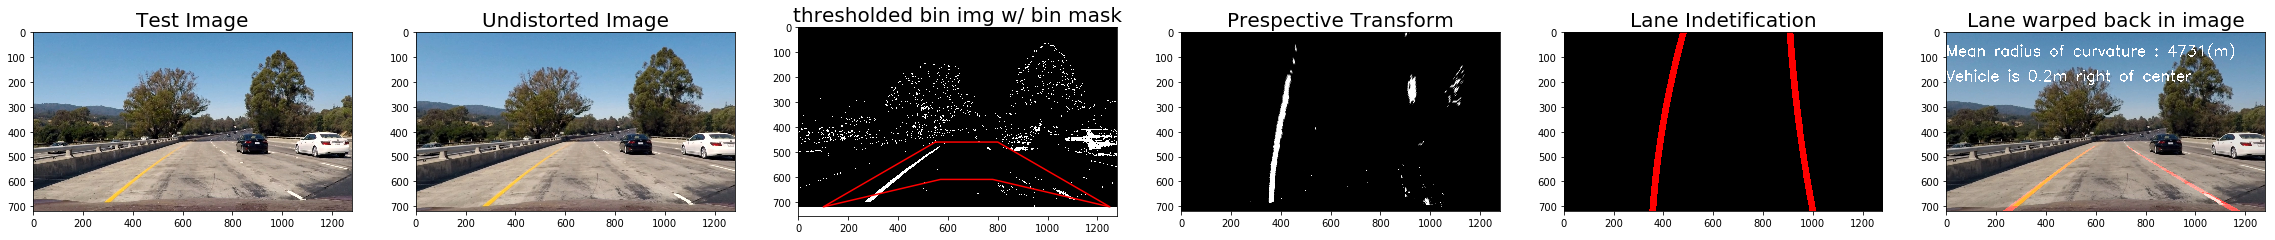

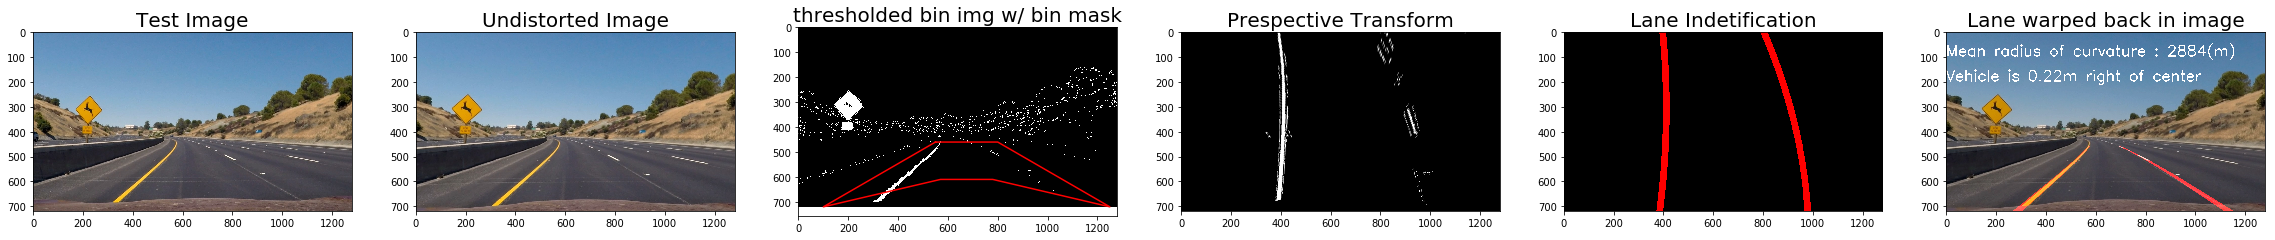

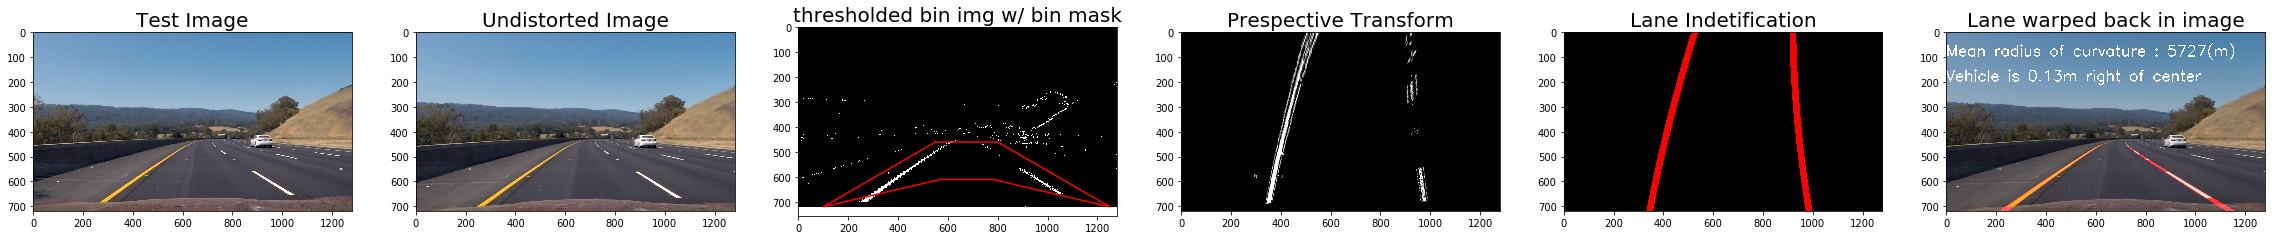

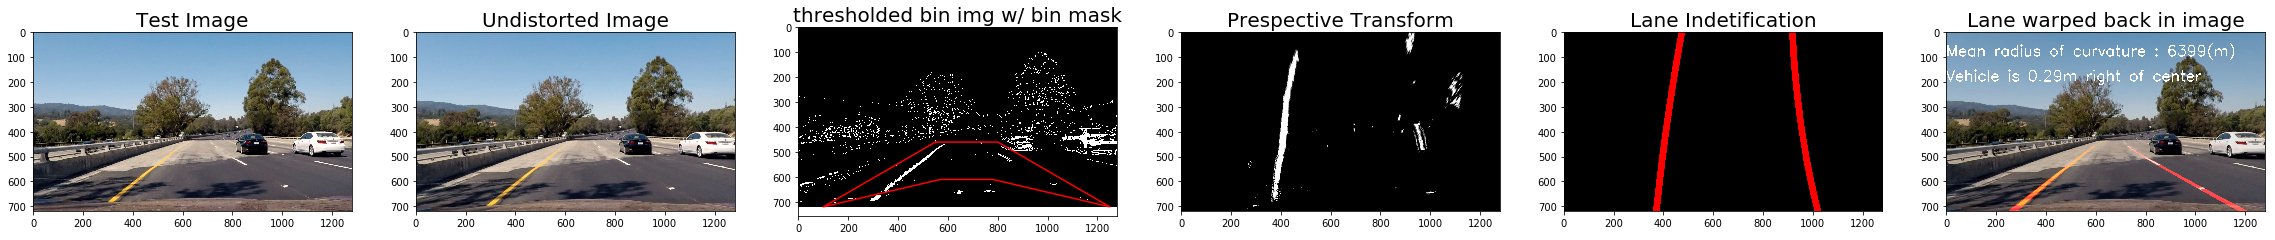

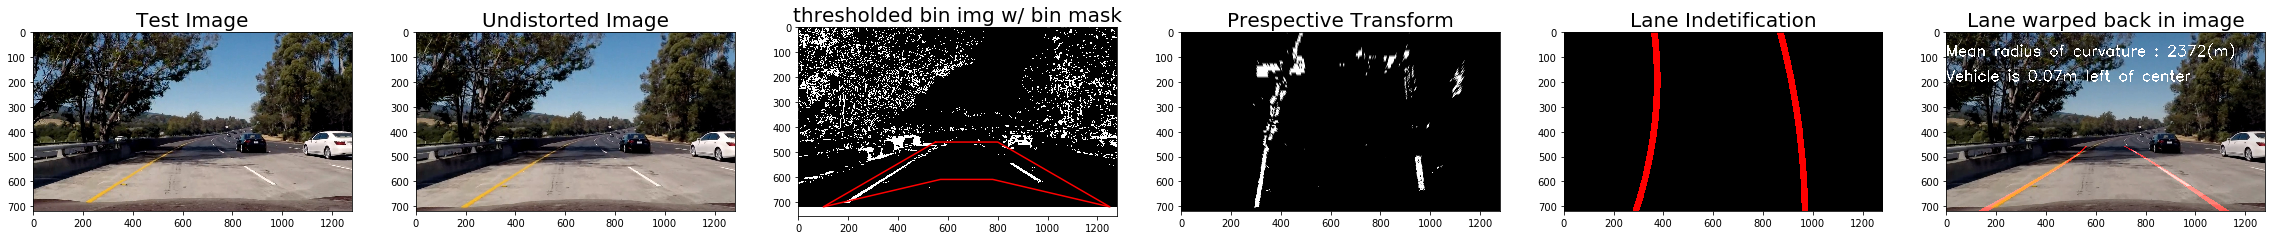

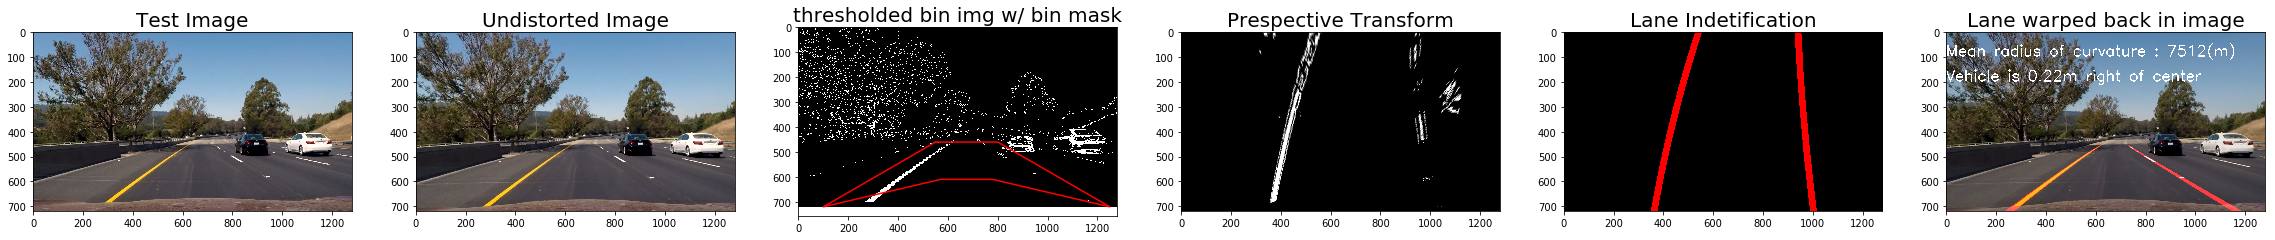

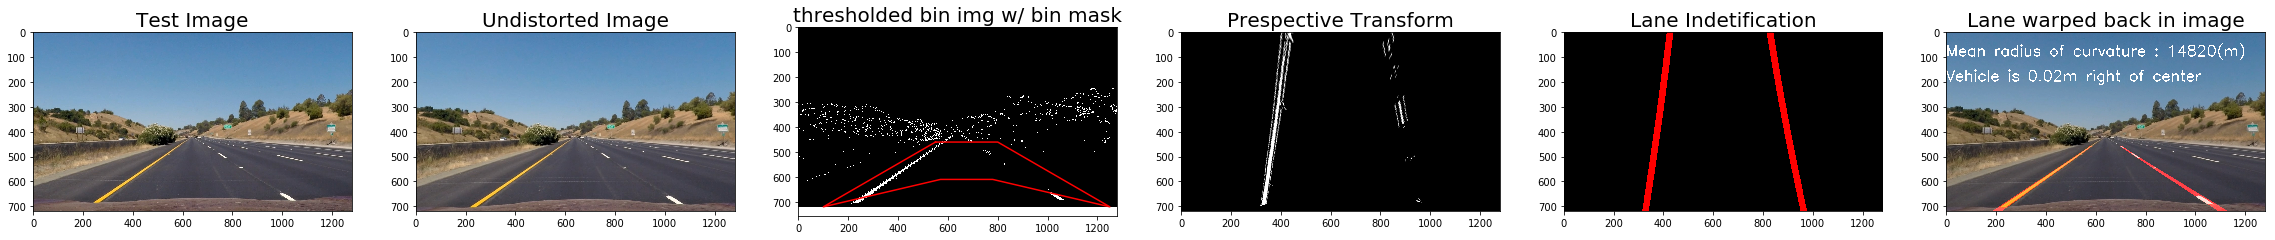

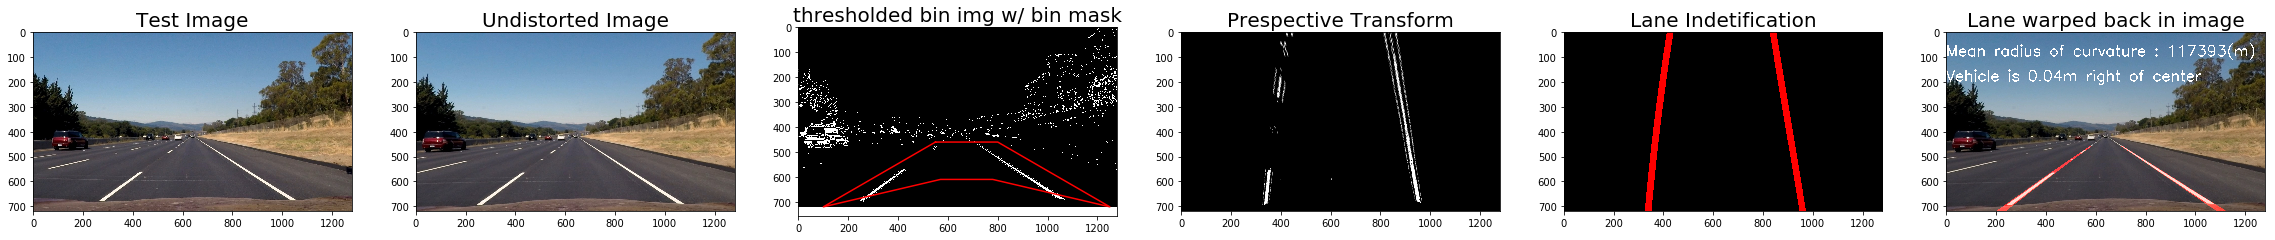

In [32]:
def visualize_result(u, bi, bw, o, f, name, testimg):
    global vertices
    
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(40,20))

#    cv2.imwrite('output_images/threshold_'+name, np.dstack((bi,bi,bi)))
#    fig.savefig('output_images/threshold_'+name)
    
    ax1.imshow(testimg[:,:,::-1])
    ax1.set_title('Test Image', fontsize=20)
    cv2.imwrite('output_images/'+name, testimg)
    
    ax2.imshow(u[:,:,::-1])
    ax2.set_title('Undistorted Image', fontsize=20)
    cv2.imwrite('output_images/undistorted_'+name, u)

    ax3.imshow(np.dstack((bi,bi,bi)))
    vertex = vertices[0,:,:].T
    ax3.plot(vertex[0],vertex[1], color='r')
    ax3.set_title('thresholded bin img w/ bin mask', fontsize=20)
    extent = ax3.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig('output_images/threshold_'+name, bbox_inches=extent)
    
    ax4.imshow(bw, cmap='gray')
    ax4.set_title('Prespective Transform', fontsize=20)
    cv2.imwrite('output_images/perspec_warp_'+name, np.dstack((bw,bw,bw)))
    
    ax5.imshow(o[:,:,::-1])
    ax5.set_title('Lane Indetification', fontsize=20)
    cv2.imwrite('output_images/lanes_'+name, o)
    
    ax6.imshow(f[:,:,::-1])
    ax6.set_title('Lane warped back in image', fontsize=20)
    cv2.imwrite('output_images/warp_back_'+name, f)
    
    plt.show()

images = glob.glob('test_images/test*.jpg')
for img in images:
    clear_polynomials()
    u,bi,bw,o,f = video_pipeline(cv2.imread(img), 1)
    visualize_result(u,bi,bw,o,f,img.split('/')[1],cv2.imread(img))

images = glob.glob('test_images/straight_lines*.jpg')
for img in images:
    clear_polynomials()
    u,bi,bw,o,f  = video_pipeline(cv2.imread(img), 1)
    visualize_result(u,bi,bw,o,f,img.split('/')[1],cv2.imread(img))

## Test videos

In [ ]:
# # Import everything needed to edit/save/watch video clips
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML

# def process_image(image):
#     # NOTE: The output you return should be a color image (3 channel) for processing video below
#     # TODO: put your pipeline here,
#     # you should return the final output (image where lines are drawn on lanes)
#     result = video_pipeline(image[:,:,::-1], 0)
#     return result[:,:,::-1]

In [ ]:
# video_out_1 = 'output_images/harder_challenge_video.mp4'
# clip1 = VideoFileClip("./harder_challenge_video.mp4")
# clear_polynomials()
# video_clip = clip1.fl_image(process_image)
# %time video_clip.write_videofile(video_out_1, audio=False)